In [62]:
#Monai is an effective framework for preprocessing NIfTI images for a pytorch pipeline
!pip install monai

In [63]:
import os
from glob import glob
from pathlib import Path
import torch
from monai.transforms import ( #d stands for dictionary
    Compose,
    LoadImaged,
    ToTensord,
    EnsureChannelFirstd,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    CastToTyped,
    ConcatItemsd,
)
from monai.data import Dataset, DataLoader
from monai.utils import first
import matplotlib.pyplot as plt
import nibabel as nib 

In [64]:
data_dir = 'data' #path from our current directory

In [65]:
#load file paths and store as a dictionary for each subject
data_root = Path("data") / "BraTS2020_TrainingData" / "MICCAI_BraTS2020_TrainingData" #create path object that points to our data directory

subjects = [] #create empy list of dictionaries
for subject_dir in sorted(data_root.glob("BraTS20_Training_*")): #sorted makes sure our folders are accessed in order, glob allows us to use *, for loop iterates over all folders
    subject = {
        "flair": subject_dir / f"{subject_dir.name}_flair.nii", #each key corresponds to a file path
        "t1": subject_dir / f"{subject_dir.name}_t1.nii",
        "t1ce": subject_dir / f"{subject_dir.name}_t1ce.nii",
        "t2": subject_dir / f"{subject_dir.name}_t2.nii",
        "seg": subject_dir / f"{subject_dir.name}_seg.nii"
    }

    # You can optionally check they all exist
    if all(p.exists() for p in subject.values()):
        subjects.append(subject)
    else:
        print(f"Missing files for {subject_dir.name}")

print(f"Loaded {len(subjects)} complete subject dictionaries.")
#print(subjects)


Missing files for BraTS20_Training_355
Loaded 368 complete subject dictionaries.


subject 0


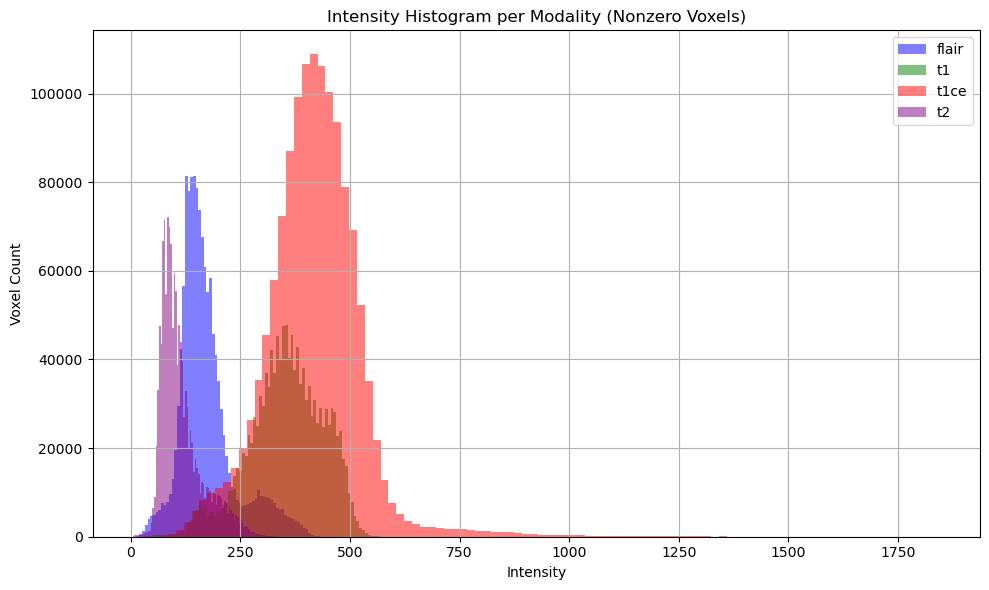

subject 1


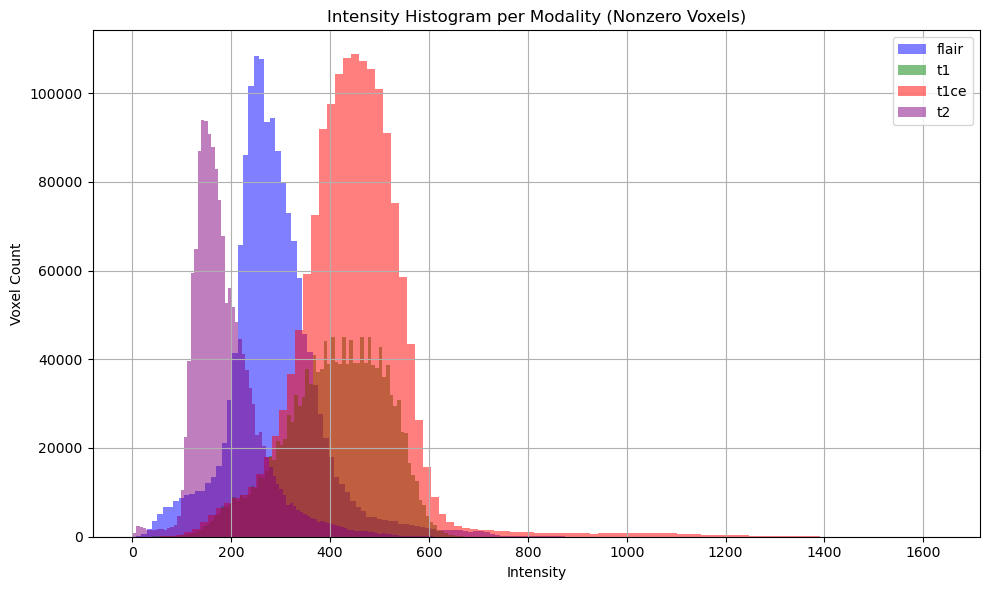

subject 2


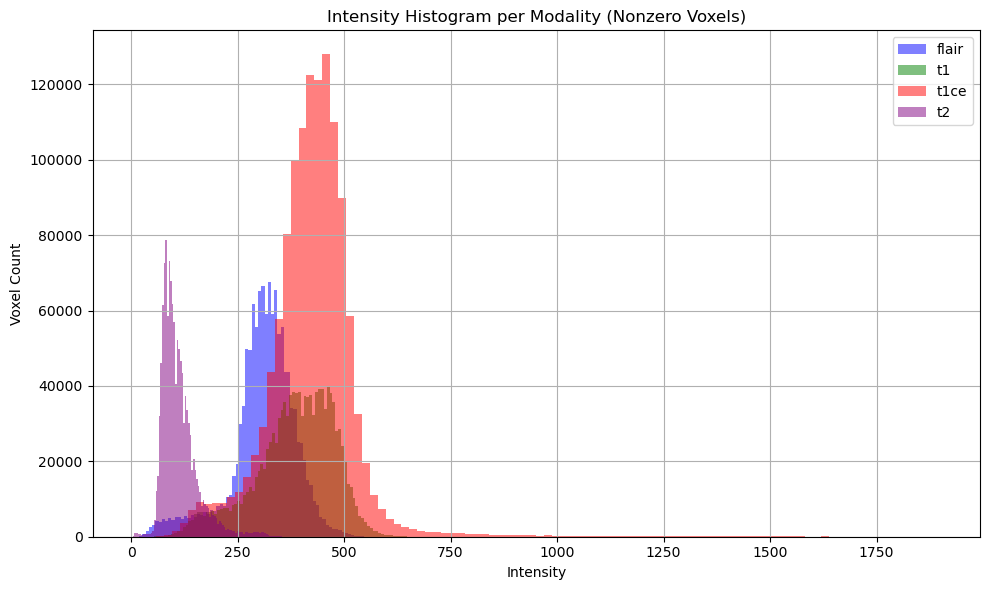

subject 3


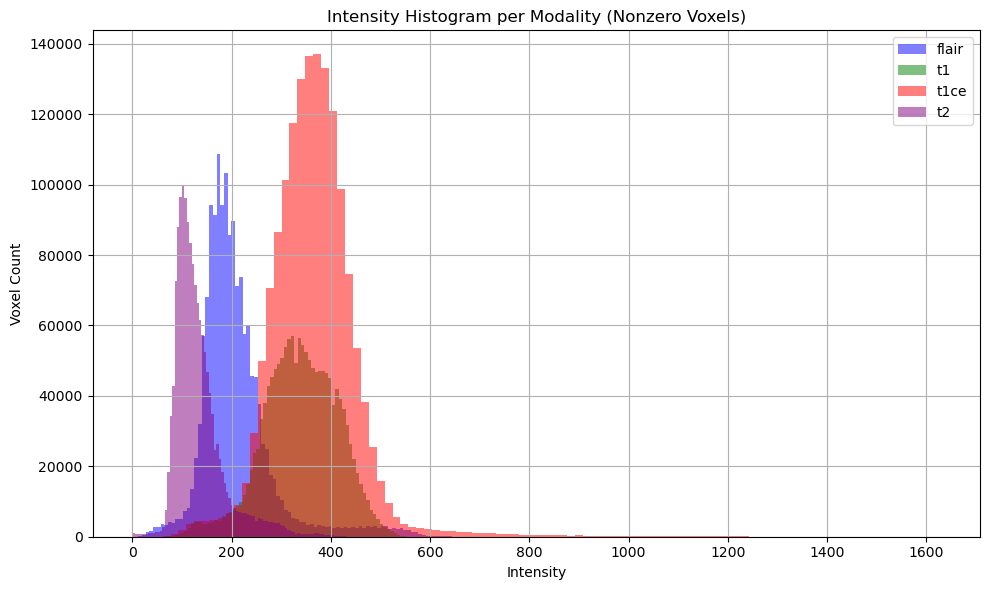

subject 4


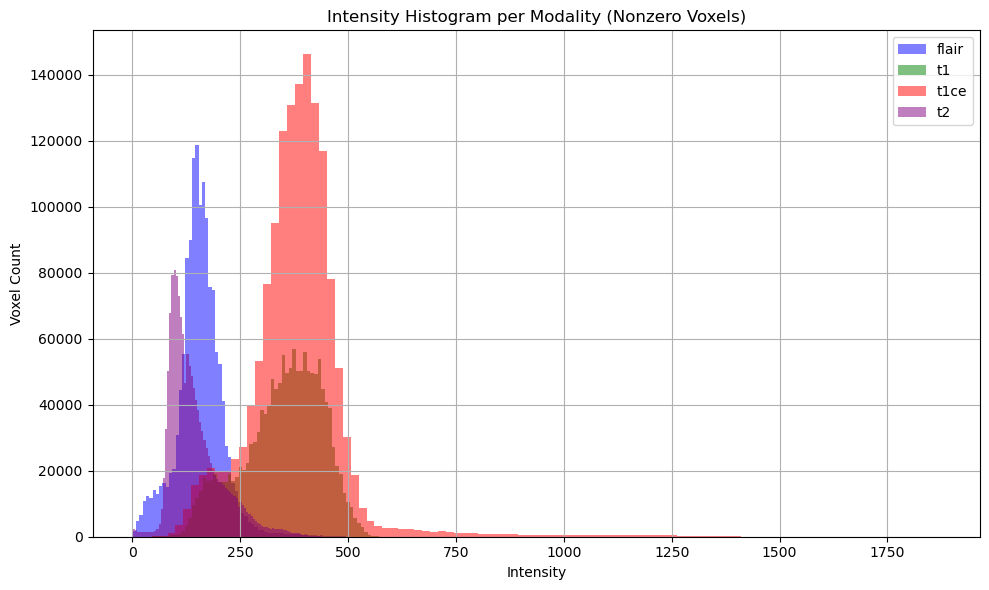

subject 5


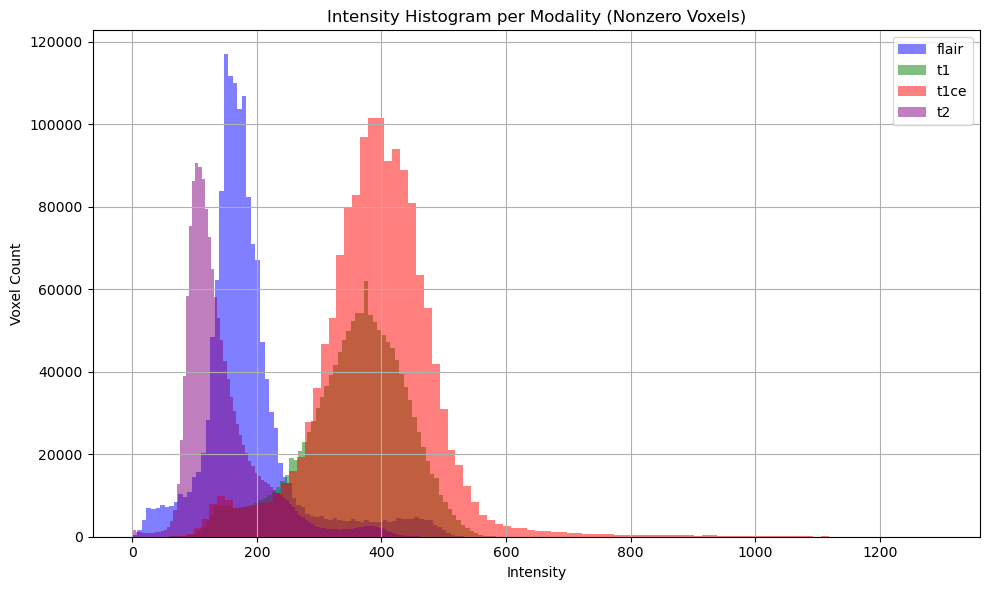

subject 6


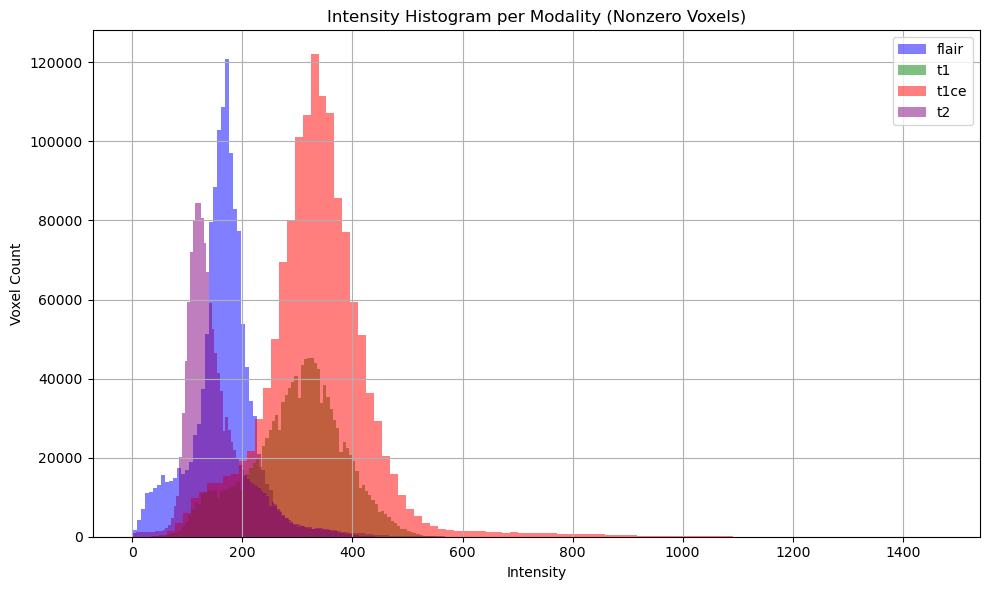

subject 7


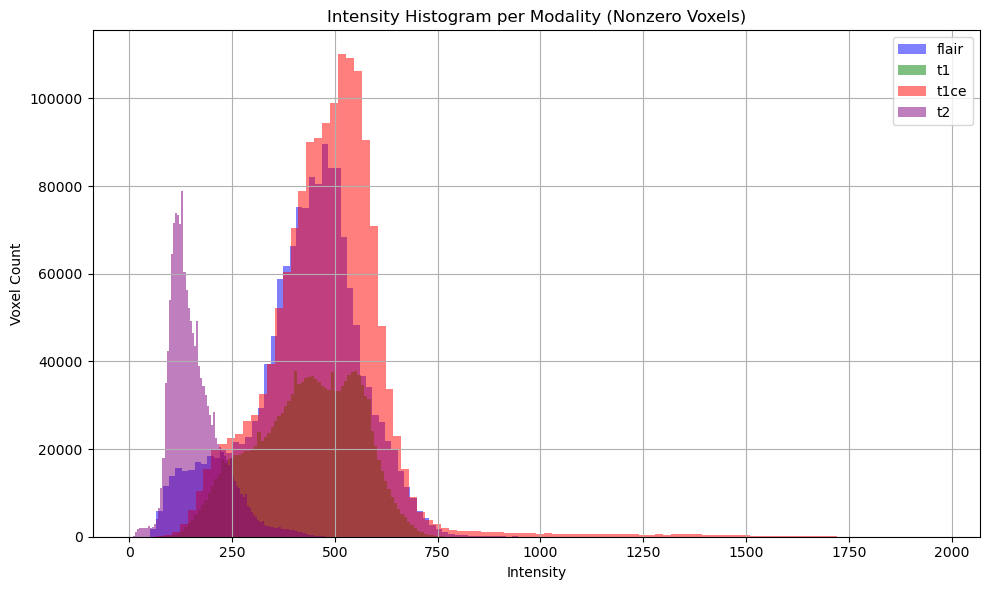

subject 8


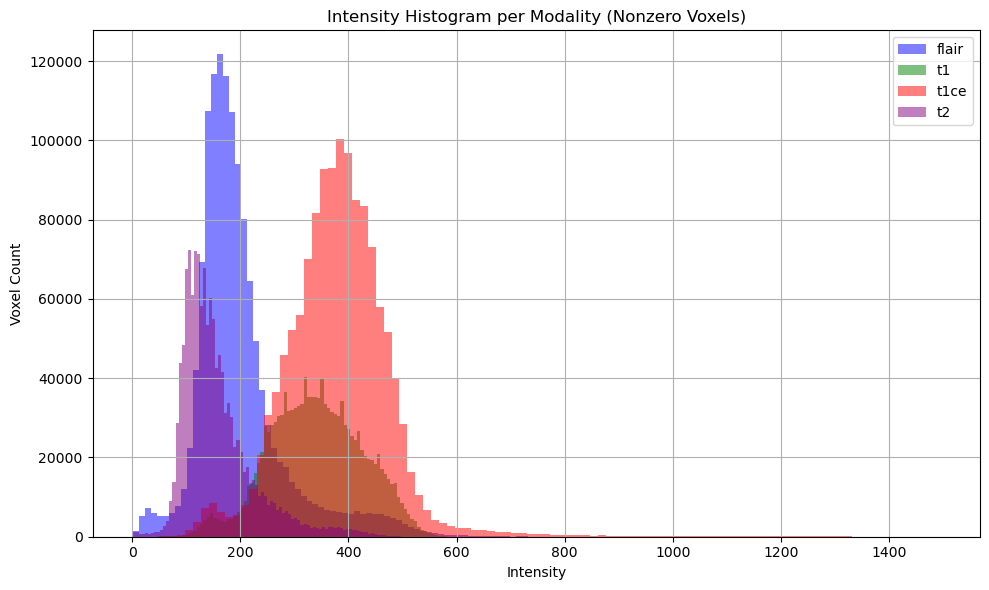

subject 9


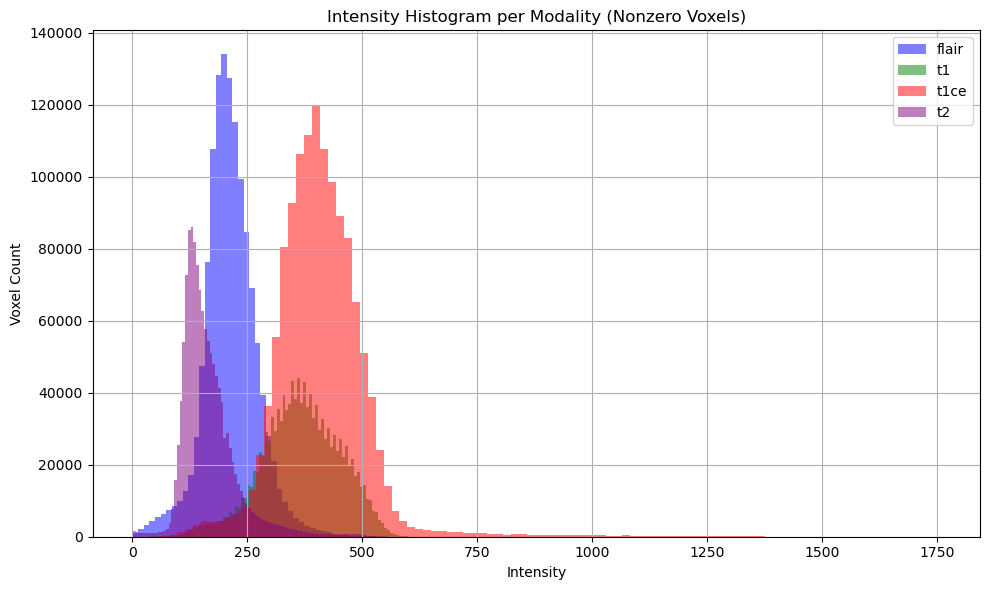

In [75]:
'''
Before we make our tensors it is important that we consider what our image contrast should be. 
We are using 4 different scan types, and it would be nice if we could find a single tight contrast range that will work for all of them
We can decide on the contrast range to use by generating histograms for each image type
supplement this with online ITK-Snap tool
'''
import matplotlib.pyplot as plt
import nibabel as nib

def plot_intensity_histograms(subject_dict):
    plt.figure(figsize=(10, 6))

    for key, color in zip(["flair", "t1", "t1ce", "t2"], ["blue", "green", "red", "purple"]):
        img = nib.load(str(subject_dict[key])).get_fdata()
        flat = img.flatten()
        flat = flat[flat > 0]  # Remove background (optional)
        plt.hist(flat, bins=100, alpha=0.5, label=key, color=color)

    plt.title("Intensity Histogram per Modality (Nonzero Voxels)")
    plt.xlabel("Intensity")
    plt.ylabel("Voxel Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
for i in range(10):
    print(f"subject {i}")
    plot_intensity_histograms(subjects[i]) #a range of 0 to 600 looks great
#plot_intensity_histograms(subjects[0])

In [76]:
#load images
#do transformations
#convert to torch tensors
original_transforms = Compose(
    [
        LoadImaged(keys=['flair', 't1', 't1ce', 't2', 'seg']), #d stands for dictionary, we load every key for 1 row (1 patient), data loader will carry this out for every row
        EnsureChannelFirstd(keys=['flair', 't1', 't1ce', 't2', 'seg']),
        #
        ToTensord(keys=['flair', 't1', 't1ce', 't2', 'seg']) #d stands for dictionary, do this AFTER transforms :)
    ]
)

#consider using itk-snap to find good contrast values
#removed clip = True under scaleintensity
'''
Take note of EnsureChannelFirst: it converts our NIfTI images from HxWxD format to CxHxWxD format
C is number of channels, in our case we want 4, each pixel will contain values from all 4 training images
D is depth, number of slices
'''

train_transforms = Compose(
    [
        LoadImaged(keys=['flair', 't1', 't1ce', 't2', 'seg']), #d stands for dictionary, we load every key for 1 row (1 patient), data loader will carry this out for every row
        EnsureChannelFirstd(keys=['flair', 't1', 't1ce', 't2', 'seg']),
        Spacingd(keys=['flair', 't1', 't1ce', 't2', 'seg'], pixdim=(1.5, 1.5, 2)), #specify height width depth of voxels, this value can vary if we dont control it
        ScaleIntensityRanged(keys=['flair', 't1', 't1ce', 't2'], a_min = 0, a_max = 600, b_min = 0.0, b_max = 1.0), #don't apply to label
        CropForegroundd(keys=['flair', 't1', 't1ce', 't2', 'seg'], source_key='t1ce'),
        #Resized(keys=['flair', 't1', 't1ce', 't2', 'seg'], spatial_size=[128, 128, 128]),
        CastToTyped(keys=["seg"], dtype=torch.int16), #labels need to be integers when fed to models, LoadImaged converts them to floats by default so we convert them back here
        ToTensord(keys=['flair', 't1', 't1ce', 't2']), #d stands for dictionary, do this AFTER transforms :)
        ConcatItemsd(keys=["flair", "t1", "t1ce","t2"], name = "image") #we stack our keys into a single tensor
    ]
)


In [77]:
#We are about to use monai to transform our images, lets examine how the metadata for these images looks before and after
def inspect_sample(dataset, index=0):
    sample = dataset[index]

    image = sample["image"]
    label = sample["seg"]

    print(f"Image type: {type(image)}")
    print(f"Image shape: {image.shape}")
    print(f"Image dtype: {image.dtype}")

    print(f"\nLabel type: {type(label)}")
    print(f"Label shape: {label.shape}")
    print(f"Label dtype: {label.dtype}")

In [78]:
'''
We now use monai wrappers for pytorch.utils.datasets
'''
orig_ds = Dataset(data=subjects, transform=original_transforms) #this will automatically handle transforms tasks for all patients, no loop needed
orig_loader = DataLoader(orig_ds, batch_size=1)

train_ds = Dataset(data=subjects, transform=train_transforms) #this will automatically handle transforms tasks for all patients, no loop needed
train_loader = DataLoader(train_ds, batch_size=1)
inspect_sample(train_ds, index=0) 
#inspection tells us a few things
#Monai has converted our data to a pytorch compatible tensor
#It has converted our training data into 4 channel tensors (one for each image type)
#Our training data it correctly being treated as floats and our training labels as integers

Image type: <class 'monai.data.meta_tensor.MetaTensor'>
Image shape: torch.Size([4, 91, 116, 68])
Image dtype: torch.float32

Label type: <class 'monai.data.meta_tensor.MetaTensor'>
Label shape: torch.Size([1, 91, 116, 68])
Label dtype: torch.int16


In [79]:
test_patient = first(train_loader) #lets load 1 slice from 1 patient to verify our transformations
orig_patient = first(orig_loader)
#print(test_patient)#this contains image and label (all 5 columns)
#print(test_patient['seg']) #print just the labels

In [80]:
print(torch.min(test_patient['t1']))
print(torch.max(test_patient['t1']))

metatensor(0.)
metatensor(1.0233)


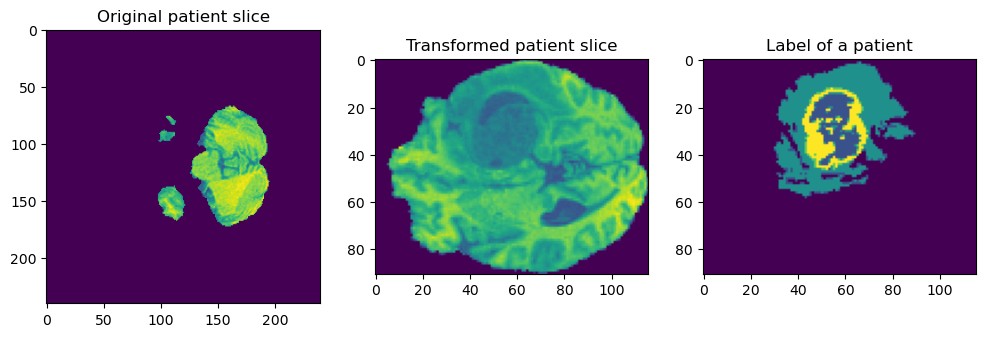

In [82]:
plt.figure('test', (12,6))#create matplots

plt.subplot(1, 3, 1) #1 line, 2 columns #I actually think the dimensions were standarddized before I got these images
plt.title('Original patient slice')
plt.imshow(orig_patient['t1'][0, 0, :, :, 30]) #index of batch and chanel, width, height, #ofslices  :== all

plt.subplot(1, 3, 2) #1 line, 2 columns
plt.title('Transformed patient slice')
plt.imshow(test_patient['t1'][0, 0, :, :, 30]) #index of batch and chanel, width, height, #ofslices  :== all

plt.subplot(1,3,3) #1 row 2 columns part 2
plt.title('Label of a patient')
plt.imshow(test_patient['seg'][0, 0, :, :,30])
plt.show()